In [7]:
%matplotlib inline
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, qiime2 as q2
from biom import load_table, Table
from biom.util import biom_open
from skbio import OrdinationResults, DistanceMatrix
from emperor import Emperor, nbinstall; nbinstall()
import qiime2 as q2

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep='\t', dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

In [6]:
mf = load_mf('data/11546_20190118-122918.txt', 'sample_name')
mf = mf.query('empo_1 == "Host-associated"').copy()

In [8]:
dm = q2.Artifact.load('braycurtis.qza').view(DistanceMatrix)

In [9]:
mf.time_point.value_counts()

baseline    127
month 6      95
month 12     75
month 18     37
month 9       5
month 24      3
month 7       2
month 21      2
month 3       2
month 15      1
month 20      1
month 1       1
month 19      1
Name: time_point, dtype: int64

In [12]:
mf['complications'] = mf.crohns_disease_behavior.isin(['inflammatory', 'stricturing', 'fistulizing'])

In [10]:
data = []

_mf = mf.loc[mf.index.intersection(dm.ids)].copy()

for host, df in _mf.groupby('host_subject_id'):
    if 'baseline' not in df.time_point.values: 
        continue

    baseline = df[df.time_point == 'baseline'].index[0]

    for timepoint in ['month 6', 'month 12', 'month 18']:
        if timepoint not in df.time_point.values:
            continue
        
        current = df[df.time_point == timepoint].index[0]
        distance = dm[baseline, current]
        
        data.append([timepoint, distance, df.loc[baseline]['has_surgery']])
data = pd.DataFrame(columns=['Months From Baseline', 'Distance', 'Surgery'], data=data)

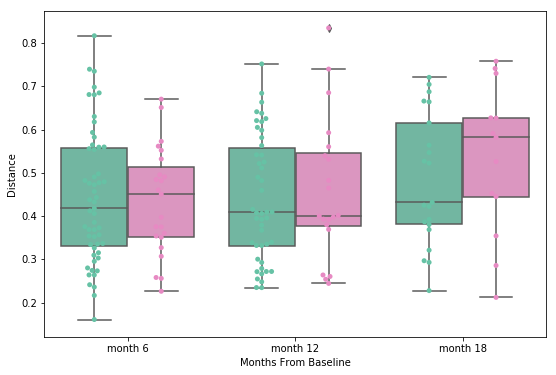

In [19]:
colors = {
    'ileocolonic': '#fc8d62',
    'colectomy': '#8da0cb',
    'none': '#66c2a5',
    'n': '#66c2a5',
    'y': '#e78ac3',
}

fig, ax = plt.subplots(figsize=(9, 6))

sns.boxplot(x='Months From Baseline', y='Distance', hue='Surgery', data=data, palette=colors, ax=ax)
sns.swarmplot(x='Months From Baseline', y='Distance', hue='Surgery', data=data, dodge=True, palette=colors, ax=ax)

ax.get_legend().set_visible(False)

fig.savefig('longitudinal.pdf', transparent=True)